In [21]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [22]:
def read_river(river_name):
    river_flow = pd.read_csv(f'{river_name}_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    river_flow['date'] = pd.to_datetime(river_flow.drop(columns='flow'))
    river_flow.set_index('date', inplace=True)
    river_flow = river_flow.drop(columns=['year', 'month', 'day'])
    return river_flow

In [23]:
englishman = read_river('Englishman')
englishman = englishman[(englishman.index.year <= 2017) & (englishman.index.year >= 2015)]
salmon = read_river('Salmon_Sayward')
salmon = salmon[(salmon.index.year <= 2017) & (salmon.index.year >= 2015)]

In [24]:
matching_dictionary = {'Englishman': 'Salmon_Sayward',
                      'Theodosia': 'Englishman',
                      'Roberts_Roberts': 'Englishman'}
timeseries = {'Englishman': englishman,
             'Salmon_Sayward': salmon}

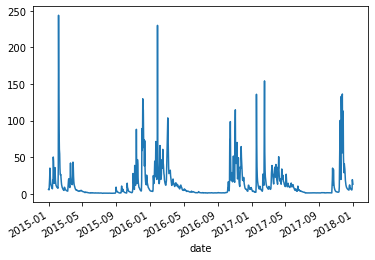

In [25]:
englishman.flow.plot();

In [26]:
diffy = englishman.index[1:] - englishman.index[:-1]
day = dt.datetime(2020, 1, 2) - dt.datetime(2020, 1, 1)
gaps = englishman[1:][diffy > day]
gap_length = diffy[diffy > day]

In [27]:
print (gaps)
print(gap_length)
gaps.index

                 flow
date                 
2015-01-05   21.11260
2016-03-05  103.68510
2016-03-14   32.30315
TimedeltaIndex(['2 days', '3 days', '5 days'], dtype='timedelta64[ns]', name='date', freq=None)


DatetimeIndex(['2015-01-05', '2016-03-05', '2016-03-14'], dtype='datetime64[ns]', name='date', freq=None)

In [30]:
filler = timeseries[matching_dictionary['Englishman']]
base = englishman
fillvalue = np.zeros((len(gaps.index), gap_length.max().days))
filldate = np.zeros((len(gaps.index), gap_length.max().days), dtype='datetime64[ns]')
for ig, gap in enumerate(gaps.index):
    summit = 0
    sumsq = 0
    count = 0
    print (gap_length[ig])
    for deltat in np.arange(-2*gap_length[ig]+day, gap_length[ig], day):
        summit = summit + filler[filler.index == gap+deltat]['flow'].values
        sumsq = sumsq + filler[filler.index == gap+deltat]['flow'].values**2
        count = count + 1
    mean = summit/count
    var = sumsq/count - mean**2/count
    print (gap, np.sqrt(var)/mean)
    sumbase = 0
    sumfill = 0
    sumratio = 0
    sumratio2 = 0
    count = 0
    for deltat in np.arange(-2*gap_length[ig]+day, -gap_length[ig]+day, day):
        sumbase = sumbase + base[base.index == gap+deltat]['flow'].values
        sumfill = sumfill + filler[filler.index == gap+deltat]['flow'].values
        ratio = base[base.index == gap+deltat]['flow'].values/filler[filler.index == gap+deltat]['flow'].values
        sumratio = sumratio + ratio
        sumratio2 = sumratio2 + ratio**2
        count = count + 1
    print (count, 'first loop')
    for deltat in np.arange(0, gap_length[ig], day):
        sumbase = sumbase + base[base.index == gap+deltat]['flow'].values
        sumfill = sumfill + filler[filler.index == gap+deltat]['flow'].values
        ratio = base[base.index == gap+deltat]['flow'].values/filler[filler.index == gap+deltat]['flow'].values
        sumratio = sumratio + ratio
        sumratio2 = sumratio2 + ratio**2
        count = count + 1
    print (count, 'second loop')
    print (sumratio, sumratio2, count)
    meanratio = sumratio/count
    varratio = sumratio2/count - meanratio**2/count
    print (np.sqrt(varratio/meanratio))
    if np.sqrt(var)/mean < np.sqrt(varratio/meanratio) : 
        uselinear = True
    else:
        uselinear = False
    for step, deltat in enumerate(np.arange(-gap_length[ig]+day, 0, day)):
        if uselinear:
            slope = (base[base.index == gap].values 
                 - base[base.index == gap-gap_length[ig]].values)/gap_length[ig].days
            fillvalue[ig, step] = base[base.index == gap-gap_length[ig]] + slope * (step+1)
        else:
            fillvalue[ig, step] = meanratio * filler[filler.index == gap + deltat].values 
        filldate[ig, step] = gap + deltat
print (fillvalue)
print (filldate)

2 days 00:00:00
2015-01-05 00:00:00 [0.99739458]
2 first loop
4 second loop
[0.81945005] [0.19786628] 4
[0.43617273]
3 days 00:00:00
2016-03-05 00:00:00 [1.06132446]
3 first loop
6 second loop
[2.05149942] [0.72630945] 6
[0.545025]
5 days 00:00:00
2016-03-14 00:00:00 [1.12298107]
5 first loop
10 second loop
[3.15793428] [0.99878489] 10
[0.53357153]
[[ 11.3493832    0.           0.           0.           0.        ]
 [ 64.62223158 113.85821754   0.           0.           0.        ]
 [ 55.26384987  47.6848076   35.68465735  31.57934278   0.        ]]
[['2015-01-04T00:00:00.000000000' '1970-01-01T00:00:00.000000000'
  '1970-01-01T00:00:00.000000000' '1970-01-01T00:00:00.000000000'
  '1970-01-01T00:00:00.000000000']
 ['2016-03-03T00:00:00.000000000' '2016-03-04T00:00:00.000000000'
  '1970-01-01T00:00:00.000000000' '1970-01-01T00:00:00.000000000'
  '1970-01-01T00:00:00.000000000']
 ['2016-03-10T00:00:00.000000000' '2016-03-11T00:00:00.000000000'
  '2016-03-12T00:00:00.000000000' '2016-03-1

In [26]:
print (gap_length[0].days)

2


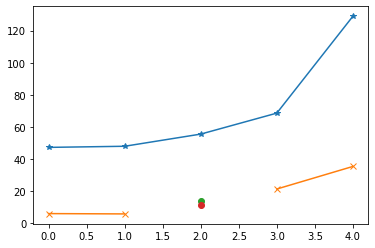

In [47]:
valuesfill = [47.1, 47.8, 55.4, 68.5, 129]
valuesbase = [5.75, 5.55, np.nan, 21.1, 35.2]
plt.plot(valuesfill, '-*')
plt.plot(valuesbase, '-x')
plt.plot(2, 13.33, 'o')
plt.plot(2, 11.35, 'o')


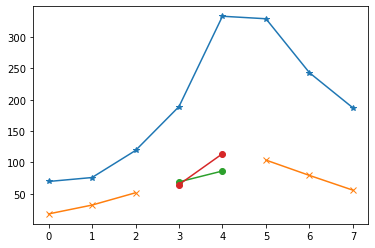

In [51]:
valuesfill = [69.6, 75.9, 119, 189, 333, 329, 243, 187]
valuesbase = [17.9, 32, 51.6, np.nan, np.nan, 103.7, 79.28, 55.77]
plt.plot(valuesfill, '-*')
plt.plot(valuesbase, '-x')
plt.plot([3, 4], [68.951547, 86.318323], 'o-')
plt.plot([3, 4], [64.62223158, 113.85821754], 'o-')


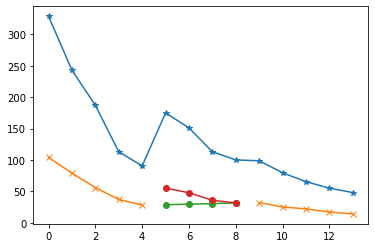

In [55]:
valuesfill = [329, 243, 187, 113, 90.6, 175, 151, 113, 100, 98.7, 79.4, 65.4, 55, 48]
valuesbase = [104, 79, 56, 37, 28, np.nan, np.nan, np.nan, np.nan, 32, 25, 22, 17, 14]
plt.plot(valuesfill, '-*')
plt.plot(valuesbase, '-x')
plt.plot([5, 6, 7, 8], [28.603182, 29.528174, 30.453166, 31.378158], 'o-')
plt.plot([5, 6, 7, 8], [55.26384987, 47.6848076, 35.68465735, 31.57934278], 'o-')

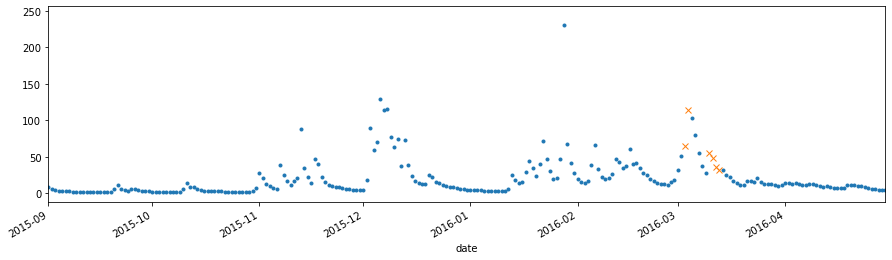

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
englishman.flow.plot(ax=ax, marker='.', linewidth=0);
ax.plot(filldate.flatten(), fillvalue.flatten(), 'x')
ax.set_xlim(dt.datetime(2015, 9, 1), dt.datetime(2016, 4, 30));

In [34]:
fillit = pd.DataFrame(index =filldate.flatten(), data = {'flow':fillvalue.flatten()})

,flow
2015-01-01,6.009292
2015-01-02,5.754686
2015-01-03,5.555931
2015-01-05,21.112600
2015-01-06,35.194280
...,...
2016-03-04,113.858218
2016-03-10,55.263850
2016-03-11,47.684808
2016-03-12,35.684657


In [32]:
for index in fillit.index:
    print (index)
    if index > np.datetime64(dt.datetime(2006, 12, 31)):
        print (index)
        englishman = englishman.append(fillit[fillit.index == index], sort=True)
        print (len(englishman.index))

2015-01-04 00:00:00
2015-01-04 00:00:00
1090
1970-01-01 00:00:00
1970-01-01 00:00:00
1970-01-01 00:00:00
1970-01-01 00:00:00
2016-03-03 00:00:00
2016-03-03 00:00:00
1091
2016-03-04 00:00:00
2016-03-04 00:00:00
1092
1970-01-01 00:00:00
1970-01-01 00:00:00
1970-01-01 00:00:00
2016-03-10 00:00:00
2016-03-10 00:00:00
1093
2016-03-11 00:00:00
2016-03-11 00:00:00
1094
2016-03-12 00:00:00
2016-03-12 00:00:00
1095
2016-03-13 00:00:00
2016-03-13 00:00:00
1096
1970-01-01 00:00:00


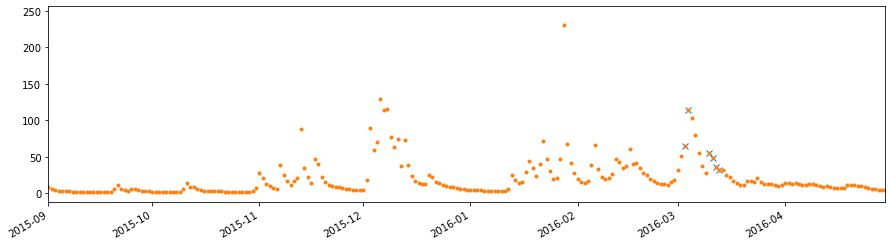

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(filldate.flatten(), fillvalue.flatten(), 'x')
englishman.flow.plot(ax=ax, marker='.', linewidth=0);
ax.set_xlim(dt.datetime(2015, 9, 1), dt.datetime(2016, 4, 30));


In [94]:
englishman[-5:]

,flow
date,
2017-12-27,5.265768
2017-12-28,7.123708
2017-12-29,19.430410
2017-12-30,16.209720
2017-12-31,13.250540


## Patch Roberts

In [6]:
roberts = read_river('Roberts_Roberts')
roberts = roberts[(roberts.index.year <= 2017) & (roberts.index.year >= 2015)]

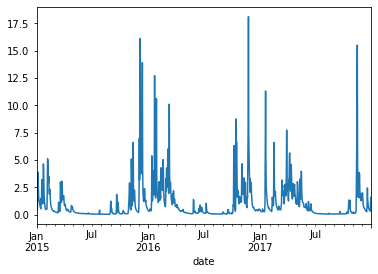

In [7]:
roberts.flow.plot();

In [8]:
diffy = roberts.index[1:] - roberts.index[:-1]
day = dt.datetime(2020, 1, 2) - dt.datetime(2020, 1, 1)
gaps = roberts[1:][diffy > day]
gap_length = diffy[diffy > day]

In [9]:
print (gaps)
print(gap_length)
gaps.index

Empty DataFrame
Columns: [flow]
Index: []
TimedeltaIndex([], dtype='timedelta64[ns]', name='date', freq=None)


DatetimeIndex([], dtype='datetime64[ns]', name='date', freq=None)

## Patch Theodosia

In [15]:
def read_river_Theodosia():
    part1 = pd.read_csv('Theodosia_Scotty_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    part2 = pd.read_csv('Theodosia_Bypass_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    part3 = pd.read_csv('Theodosia_Diversion_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    for part in [part1, part2, part3]:
        part['date'] = pd.to_datetime(part.drop(columns='flow'))
        part.set_index('date', inplace=True)
        part.drop(columns=['year', 'month', 'day'], inplace=True)
    part1 = part1.rename(columns={'flow': 'Scotty'})
    part2 = part2.rename(columns={'flow': 'Bypass'})
    part3 = part3.rename(columns={'flow': 'Diversion'})
    theodosia = (part1.merge(part2, how='inner', on='date')).merge(part3, how='inner', on='date')
    theodosia['flow'] = theodosia['Scotty'] + theodosia['Diversion'] - theodosia['Bypass']
    return theodosia

In [16]:
theodosia = read_river_Theodosia()
theodosia = theodosia[(theodosia.index.year <= 2017) & (theodosia.index.year >= 2015)]

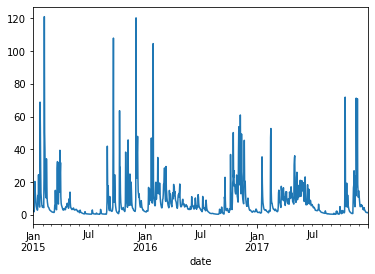

In [17]:
theodosia.flow.plot();

In [18]:
diffy = theodosia.index[1:] - theodosia.index[:-1]
day = dt.datetime(2020, 1, 2) - dt.datetime(2020, 1, 1)
gaps = theodosia[1:][diffy > day]
gap_length = diffy[diffy > day]

In [19]:
print (gaps)
print(gap_length)
gaps.index

Empty DataFrame
Columns: [Scotty, Bypass, Diversion, flow]
Index: []
TimedeltaIndex([], dtype='timedelta64[ns]', name='date', freq=None)


DatetimeIndex([], dtype='datetime64[ns]', name='date', freq=None)